In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from random import randint, random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from src.pecan_dataport.participant_preprocessing import PecanParticipantPreProcessing

# Classes and methods creation

In [24]:
def MSEError(labels, predictions):
    return np.sum(np.diff([labels, predictions], axis=0)**2)/len(predictions)

def RMSEError(labels, predictions):
    return (MSEError(labels, predictions))**0.5

def MAEError(labels, predictions):
    return np.sum(abs(np.diff([labels, predictions], axis=0)))/len(predictions)

def MAPEError(labels, predictions):
    return np.sum(abs(np.divide(np.diff([labels, predictions], axis=0), labels)))/len(predictions)

def descale(descaler, values):
    values_2d = np.array(values)[:, np.newaxis]
    return descaler.inverse_transform(values_2d).flatten()

def PolarPlotMaker(labels: list, values: list, polar_color:str, polar_legend: str, filename:str="plot"):
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, values, color=polar_color, linewidth=1)
    # Fill it in.
    ax.fill(angles, values, color=polar_color, alpha=0.25)

    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(np.degrees(angles), labels)

    for label, angle in zip(ax.get_xticklabels(), angles):
        if angle in (0, np.pi):
            label.set_horizontalalignment('center')
        elif 0 < angle < np.pi:
            label.set_horizontalalignment('left')
        else:
            label.set_horizontalalignment('right')

    ax.set_rlabel_position(180 / num_vars)
    ax.set_title(polar_legend, y=1.08)
    plt.savefig(f'methodology/imgs/results/reports/PCA_error_{filename}.eps', dpi=600, bbox_inches='tight')
    plt.savefig(f'methodology/imgs/results/reports/PCA_error_{filename}.svg', dpi=600, bbox_inches='tight')
    plt.savefig(f'methodology/imgs/results/reports/PCA_error_{filename}.png', dpi=600, bbox_inches='tight')

    plt.show()

In [25]:
pecan_dataset = PecanParticipantPreProcessing('661_test_30_pca', 'data/participants_data/1min/', 60)
default_scaler = pecan_dataset.get_scaler()

[!] - Trainable dataframe shape - (129086, 18)
[*] Train dataframe shape: (90360, 18)
[*] Validation dataframe shape: (25817, 18)
[*] Test dataframe shape: (12909, 18)


100%|█████████████████████████████████████████████████████████████████████████| 25757/25757 [00:01<00:00, 14307.96it/s]


[!] Train sequence shape: (60, 18)
[!] Val sequence shape: (60, 18)


In [26]:
with open(f'etc/results/test/661_test_30_pca/result_report.json') as json_file:
    PCA_data = json.load(json_file)
    json_file.close()

with open(f'etc/results/test/661_test_30_LSTM_shap/result_report.json') as json_file:
    SHAP_data = json.load(json_file)
    json_file.close()




## PCA Prediction

In [27]:
test_predictions_data = PCA_data 
new_prediction_data = []
new_result_data = []
for model in test_predictions_data:
    for prediction in model['predict']:
        prediction['model'] = model['model']
    for result in model['test']:
        result['model'] = model['model']
    new_result_data += model['test']
    new_prediction_data += model['predict']
complete_prediction_df = pd.DataFrame(new_prediction_data)
complete_result_df = pd.DataFrame(new_result_data)

In [28]:
shap_test_predictions_data = SHAP_data 
shap_new_prediction_data = []
for model in shap_test_predictions_data:
    for prediction in model['predict']:
        prediction['model'] = model['model']
#     for result in model['test']:
#         result['model'] = model['model']
#     new_result_data += model['test']
    shap_new_prediction_data += model['predict']
shap_complete_prediction_df = pd.DataFrame(shap_new_prediction_data)
shap_complete_prediction_df

,label,model_output,loss,model
0,-0.531253,-0.521030,0.000105,LSTM
1,-0.529845,-0.519054,0.000116,LSTM
2,-0.527775,-0.517098,0.000114,LSTM
3,-0.526451,-0.514608,0.000140,LSTM
4,-0.525871,-0.513532,0.000152,LSTM
...,...,...,...,...
12844,-0.739217,-0.735596,0.000013,LSTM
12845,-0.735160,-0.729542,0.000032,LSTM
12846,-0.735243,-0.727947,0.000053,LSTM
12847,-0.741204,-0.728466,0.000162,LSTM


## Results

In [29]:
complete_result_df

,test/MAE,test/MAPE,test/SMAPE,test/WMAPE,test/MSE,test/RMSE,test/MSLE,test/test_loss,model
0,0.026051,0.161302,0.100558,0.161302,0.002855,0.026051,0.017401,0.002855,RNN
1,0.040248,0.207194,0.128130,0.207194,0.004104,0.040248,0.021818,0.004104,LSTM
2,0.029107,0.165222,0.103902,0.165222,0.003213,0.029107,0.018365,0.003213,GRU
3,0.050360,0.398465,0.182121,0.398465,0.007353,0.050360,0.059671,0.007353,TST
4,0.168392,0.840952,0.447263,0.840952,0.037450,0.168392,0.207003,0.037450,Transformer
5,0.099664,0.335914,0.276638,0.335914,0.013043,0.099664,0.093992,0.013043,TCN


In [30]:
labels = np.array(complete_prediction_df[complete_prediction_df['model'] == 'GRU'].label)

In [31]:
calc_result = []

for model in list(complete_result_df.model):
    predictions = np.array(complete_prediction_df[complete_prediction_df['model'] == model].model_output)
    calc_result.append({
        'calculate_MSE':MSEError(labels, predictions),
        'calculate_RMSE':RMSEError(labels, predictions),
        'calculate_MAE':MAEError(labels, predictions),
        'calculate_MAPE': MAPEError(labels, predictions),
        'r2': r2_score(labels, predictions),
        'model': model
    })
calc_result_df = pd.DataFrame(calc_result)
base_result = calc_result_df.copy()
calc_result_df.to_csv('etc/results/metrics/pca_metrics.csv', sep=';', index=False)

In [32]:
calc_result_df

,calculate_MSE,calculate_RMSE,calculate_MAE,calculate_MAPE,r2,model
0,0.002855,0.053434,0.026051,0.161302,0.927130,RNN
1,0.004104,0.064062,0.040248,0.207194,0.895259,LSTM
2,0.003213,0.056681,0.029107,0.165222,0.918004,GRU
3,0.007353,0.085752,0.050360,0.398466,0.812328,TST
4,0.037450,0.193519,0.168392,0.840950,0.044209,Transformer
5,0.013043,0.114206,0.099664,0.335913,0.667119,TCN


['RNN', 'LSTM', 'GRU', 'TST', 'Transformer', 'TCN']


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


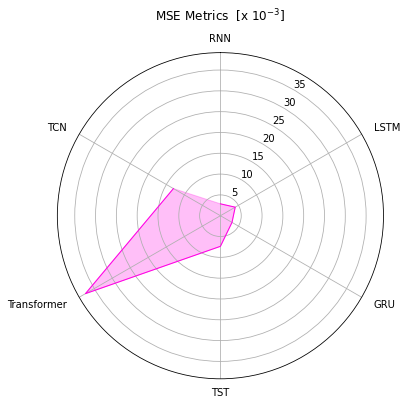

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


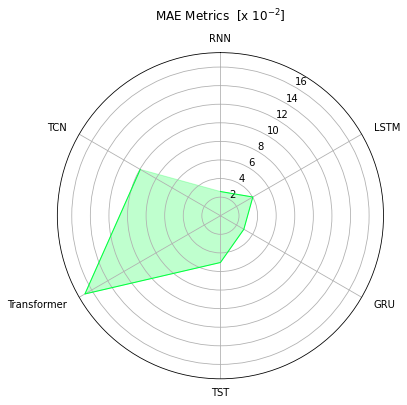

In [33]:
models_labels = calc_result_df['model'].tolist()
print(models_labels)
MSE_Values = (calc_result_df['calculate_MSE']* 1000).tolist() 
PolarPlotMaker(models_labels, MSE_Values, '#FF00E4', polar_legend=r"MSE Metrics  [x $10^{-3}$] ", filename='MSE_Metrics')

MAPE_Values = (calc_result_df['calculate_MAE'] * 100).tolist()
PolarPlotMaker(models_labels, MAPE_Values, '#00FF3E', polar_legend=r"MAE Metrics  [x $10^{-2}$] ", filename='MaE_Metrics')

In [16]:
descaler = MinMaxScaler()
descaler.min_, descaler.scale_ = default_scaler.min_[-1], default_scaler.scale_[-1]

In [19]:
descaled_rnn_prediction = descale(descaler, complete_prediction_df[complete_prediction_df['model'] == 'RNN'].model_output)
descaled_gru_prediction = descale(descaler, complete_prediction_df[complete_prediction_df['model'] == 'GRU'].model_output)
descaled_lstm_prediction = descale(descaler, complete_prediction_df[complete_prediction_df['model'] == 'LSTM'].model_output)
descaled_shap_lstm_prediction = descale(descaler, shap_complete_prediction_df[shap_complete_prediction_df['model'] == 'LSTM'].model_output)
descaled_label = descale(descaler, labels)

# Results

In [12]:
calc_result_df

,calculate_MSE,calculate_RMSE,calculate_MAE,calculate_MAPE,r2,model
0,0.002855,0.053434,0.026051,0.161302,0.927130,RNN
1,0.004104,0.064062,0.040248,0.207194,0.895259,LSTM
2,0.003213,0.056681,0.029107,0.165222,0.918004,GRU
3,0.007353,0.085752,0.050360,0.398466,0.812328,TST
4,0.037450,0.193519,0.168392,0.840950,0.044209,Transformer


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


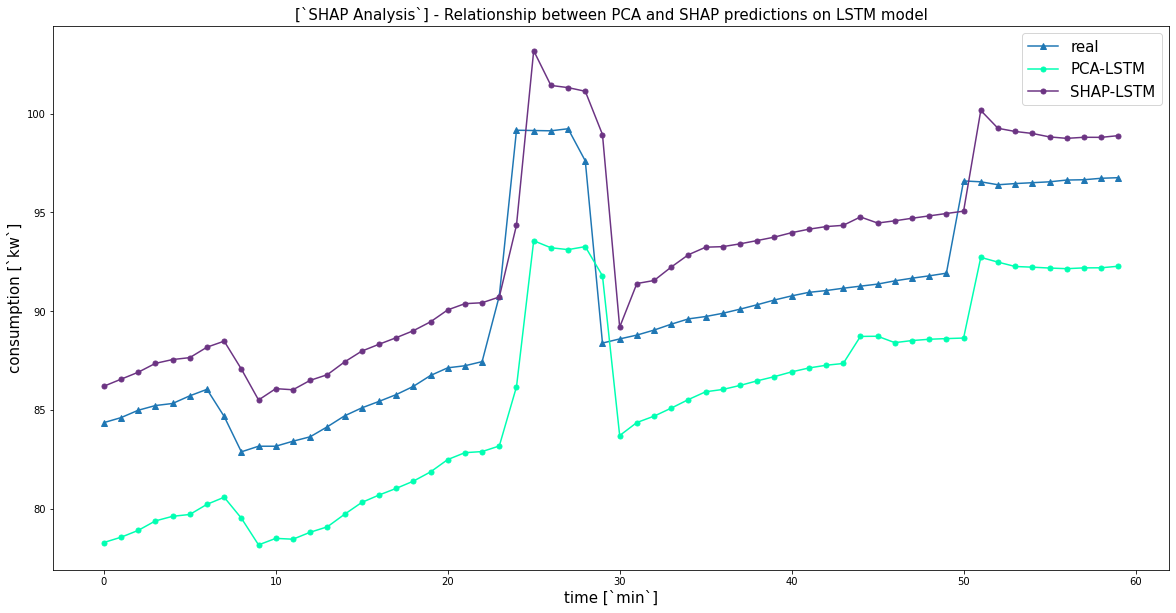

In [22]:
plt.figure(figsize=(20, 10))
plt.title(f'[`SHAP Analysis`] - Relationship between PCA and SHAP predictions on LSTM model', fontsize=15)
plt.plot(descaled_label[:60], '^', ls='-',label='real')
plt.plot(descaled_lstm_prediction[:60], '.', ms = 10, ls = '-', c = '#00FFB2',label='PCA-LSTM')
plt.plot(descaled_shap_lstm_prediction[:60], '.', ms = 10, ls = '-', c = '#6C3483',label='SHAP-LSTM')


plt.xlabel('time [`min`]', fontsize=15)
plt.ylabel('consumption [`kw`]', fontsize=15)
plt.legend(fontsize=15)
# plt.grid()
plt.savefig(f'methodology/imgs/results/forecasting/shap_pca_LSTM_model_forecasting.eps', dpi=600, bbox_inches='tight')
plt.savefig(f'methodology/imgs/results/forecasting/shap_pca_LSTM_model_forecasting.svg', dpi=600, bbox_inches='tight')
plt.savefig(f'methodology/imgs/results/forecasting/shap_pca_LSTM_model_forecasting.png', dpi=600, bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


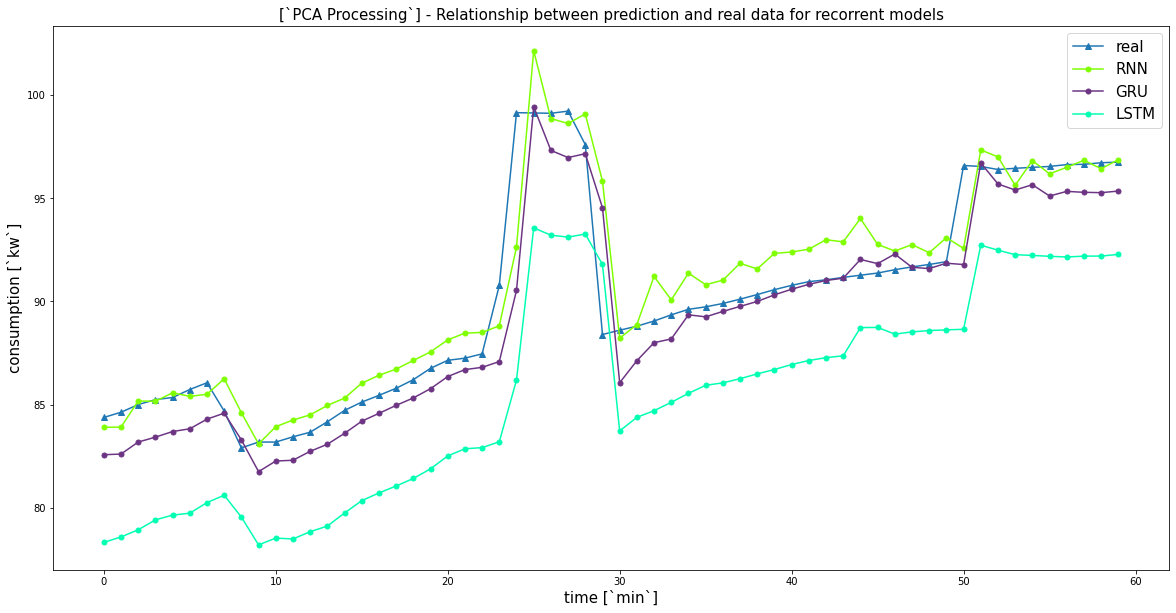

In [14]:
plt.figure(figsize=(20, 10))
plt.title(f'[`PCA Processing`] - Relationship between prediction and real data for recorrent models', fontsize=15)
plt.plot(descaled_label[:60], '^', ls='-',label='real')
plt.plot(descaled_rnn_prediction[:60], '.', ms = 10, ls = '-', c = '#7FFF00',label='RNN')
plt.plot(descaled_gru_prediction[:60], '.', ms = 10, ls = '-', c = '#6C3483',label='GRU')
plt.plot(descaled_lstm_prediction[:60], '.', ms = 10, ls = '-', c = '#00FFB2',label='LSTM')


plt.xlabel('time [`min`]', fontsize=15)
plt.ylabel('consumption [`kw`]', fontsize=15)
plt.legend(fontsize=15)
plt.savefig(f'methodology/imgs/results/forecasting/pca_baseline_models_forecasting.eps', dpi=600, bbox_inches='tight')
plt.savefig(f'methodology/imgs/results/forecasting/pca_baseline_models_forecasting.svg', dpi=600, bbox_inches='tight')
plt.savefig(f'methodology/imgs/results/forecasting/pca_baseline_models_forecasting.png', dpi=600, bbox_inches='tight')
plt.show()